# ANN 3rd assingment
## Alireza Mottaghi - 400222089

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'architectural-heritage-elements-image64-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1854018%2F3027062%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240713%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240713T162621Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8d2fad9a8fa5387ef95dbbda2d81ecf7ab83620e40ef8892b0683718d6d2ccbb4e0f619344f1fa17c68c3d7d592b523c56196e6a50fcb294b2f213a752a8a0e57d57d3021453d37a06824828b71d49e70bfc15c0e30808fede5cf669809dccd10e7284f62a0b151a3faabb6344b70e8999817bb9b19d241e8a0217a9a605568edae6f058aafd5416726113efbe44279650466276009380977b5ba2be2879c812171dc309a78b3b5a55458876e7240ef900af5a2794209907e14fd4ceb5e68f340b1444795500cf3046dff7c108bfa8b6e88da9322f877f00288af3336c03ba1653015263dbb854396eb6e1872652fadb32a0a953ab7ebda7902fb61ca287fb9a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 38587496 bytes downloaded
Downloaded and uncompressed: architectural-heritage-elements-image64-dataset
Data source import complete.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='/kaggle/input/architectural-heritage-elements-image64-dataset/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = datasets.ImageFolder(root='/kaggle/input/architectural-heritage-elements-image64-dataset/test', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


print("Number of training samples:", len(train_dataset))
print("Detected classes:", train_dataset.classes)

Number of training samples: 10130
Detected classes: ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'vault']


In [7]:
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(512 * 2 * 2, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = CNN()
device = torch.device("cuda")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []
train_f1_scores, test_f1_scores = [], []

for epoch in tqdm(range(20)):
    model.train()
    running_loss = 0.0
    train_labels = []
    train_predictions = []
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_accuracies.append(train_accuracy)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_labels, train_predictions, average='macro', zero_division='warn')
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    model.eval()
    running_loss = 0.0
    test_labels = []
    test_predictions = []
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_labels.extend(labels.cpu().numpy())
            test_predictions.extend(predicted.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_accuracies.append(test_accuracy)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='macro', zero_division='warn')
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1_scores.append(test_f1)

    print(f'Epoch {epoch+1}, Train/Test Loss: {train_loss:.4f}/{test_loss:.4f}, Accuracy: {train_accuracy:.4f}/{test_accuracy:.4f}')


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Train/Test Loss: 1.5711/1.4609, Accuracy: 0.4399/0.5014
Epoch 2, Train/Test Loss: 1.1795/1.1503, Accuracy: 0.6000/0.5905
Epoch 3, Train/Test Loss: 0.9801/0.9846, Accuracy: 0.6794/0.6681
Epoch 4, Train/Test Loss: 0.8524/0.9191, Accuracy: 0.7221/0.7073
Epoch 5, Train/Test Loss: 0.7765/0.9164, Accuracy: 0.7577/0.6973
Epoch 6, Train/Test Loss: 0.6705/0.7931, Accuracy: 0.7853/0.7443
Epoch 7, Train/Test Loss: 0.5667/0.9092, Accuracy: 0.8160/0.7429
Epoch 8, Train/Test Loss: 0.5119/0.7560, Accuracy: 0.8343/0.7692
Epoch 9, Train/Test Loss: 0.4421/0.7153, Accuracy: 0.8565/0.7999
Epoch 10, Train/Test Loss: 0.4071/0.7639, Accuracy: 0.8723/0.7977
Epoch 11, Train/Test Loss: 0.3570/0.7088, Accuracy: 0.8850/0.7970
Epoch 12, Train/Test Loss: 0.3148/0.6253, Accuracy: 0.8972/0.8098
Epoch 13, Train/Test Loss: 0.2856/0.6957, Accuracy: 0.9090/0.8063
Epoch 14, Train/Test Loss: 0.2555/0.6650, Accuracy: 0.9203/0.8269
Epoch 15, Train/Test Loss: 0.2444/0.6981, Accuracy: 0.9303/0.8162
Epoch 16, Train/Tes

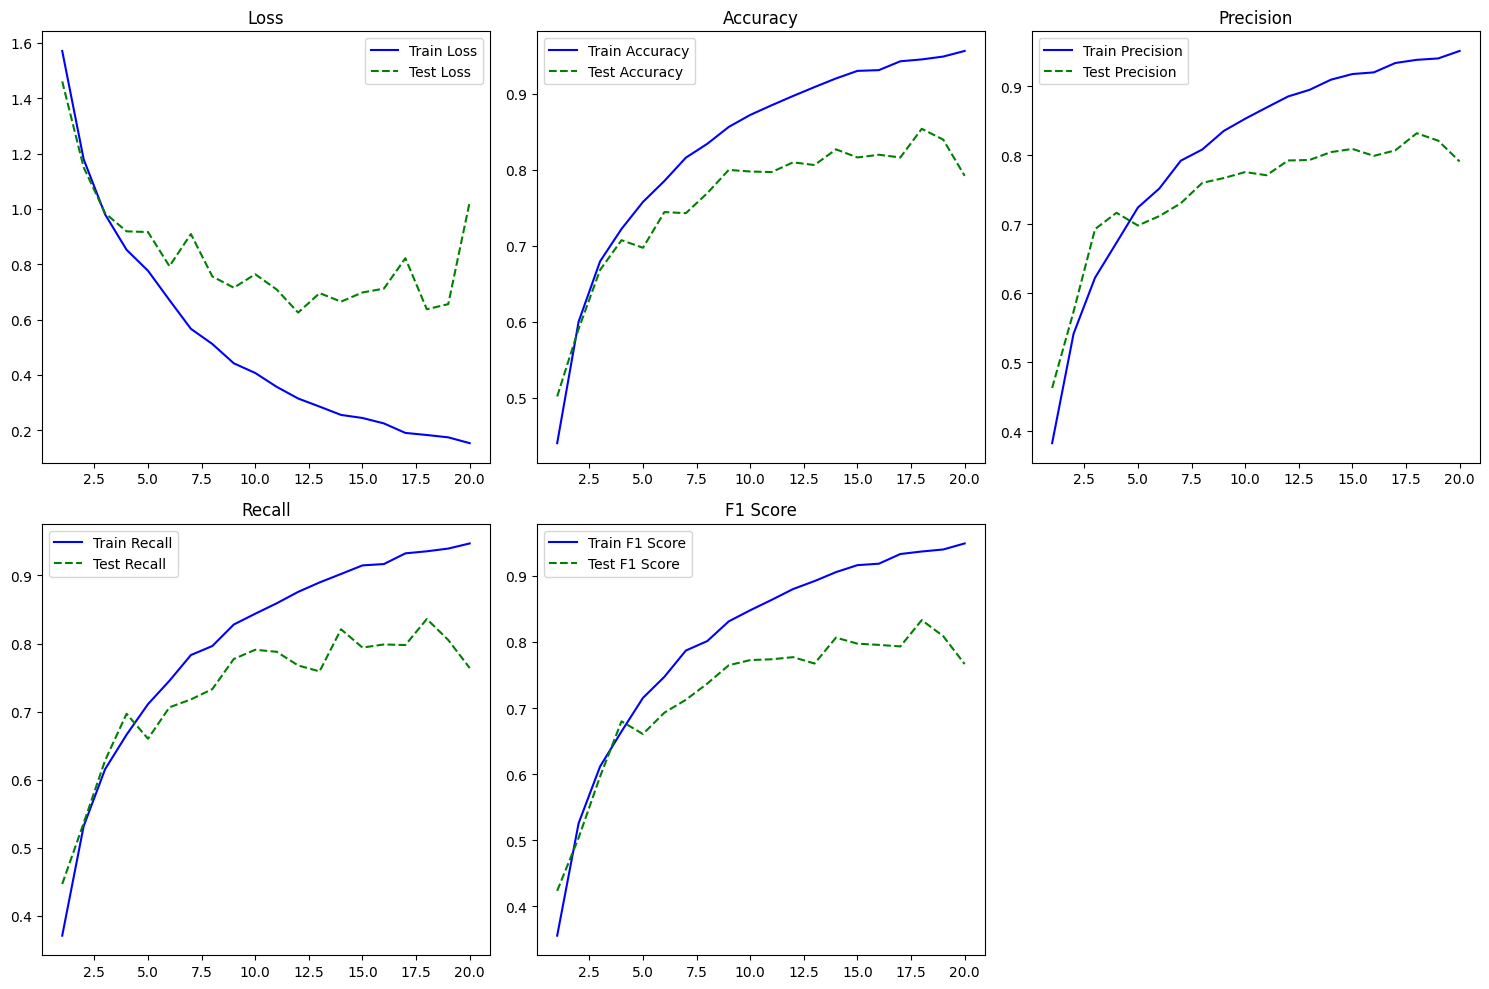

In [8]:
epochs = range(1, 21)
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, test_losses, 'g--', label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, test_accuracies, 'g--', label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_precisions, 'b-', label='Train Precision')
plt.plot(epochs, test_precisions, 'g--', label='Test Precision')
plt.title('Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_recalls, 'b-', label='Train Recall')
plt.plot(epochs, test_recalls, 'g--', label='Test Recall')
plt.title('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_f1_scores, 'b-', label='Train F1 Score')
plt.plot(epochs, test_f1_scores, 'g--', label='Test F1 Score')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2

In [10]:
class CNNVisualizer:
    def __init__(self, model):
        self.model = model
        self.activations = []
        self.gradients = []
        self.register_hooks()

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def register_hooks(self):
        for layer in self.model.modules():
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(self.save_activation)
                layer.register_backward_hook(lambda module, grad_input, grad_output: self.save_gradient(grad_output[0]))

    def visualize(self, input_image, selected_layer, selected_filter):
        input_image = input_image.to(device)
        self.model.eval()
        self.activations = []
        self.gradients = []

        output = self.model(input_image)

        self.model.zero_grad()

        activation = self.activations[selected_layer]
        activation = activation[0, selected_filter]

        mean_activation = activation.mean()

        mean_activation.backward()

        gradient = self.gradients[selected_layer]
        pooled_gradient = torch.mean(gradient, dim=[0, 2, 3])

        for i in range(gradient.shape[1]):
            self.activations[selected_layer][0, i] *= pooled_gradient[i]

        visualization = torch.mean(self.activations[selected_layer], dim=1).squeeze()

        return visualization.detach()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


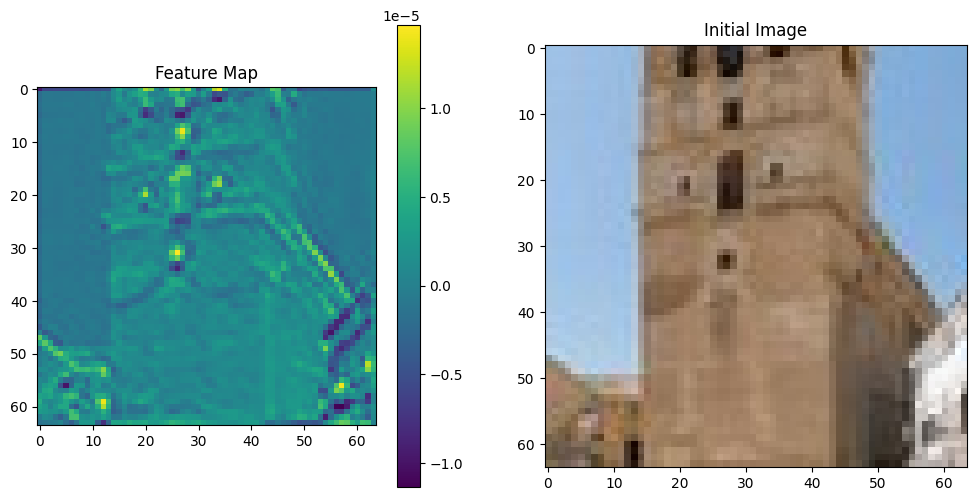

In [11]:
import matplotlib.pyplot as plt

visualizer = CNNVisualizer(model)
selected_layer = 0
selected_filter = 10

from PIL import Image
img = Image.open("/kaggle/input/architectural-heritage-elements-image64-dataset/test/bell_tower/1261.jpg")
input_image = transform(img)
input_image = input_image.unsqueeze(0)

visualization = visualizer.visualize(input_image, selected_layer, selected_filter)

additional_image_path = '/kaggle/input/architectural-heritage-elements-image64-dataset/test/bell_tower/1261.jpg'
additional_image = Image.open(additional_image_path)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

feature_image = axs[0].imshow(visualization.cpu().numpy(), cmap='viridis')
axs[0].set_title("Feature Map")
fig.colorbar(feature_image, ax=axs[0])

axs[1].imshow(additional_image)
axs[1].set_title("Initial Image")

plt.show()

In [12]:
import numpy as np

model.eval()
input_transform = transforms.Compose([
    transforms.Normalize((0, 0, 0), (5, 5, 5))
])

def generate_image_of_class(class_name, model, path=None, plot_initial=True):

    if path:
        img = np.array(Image.open(path)).astype('float32')/255
        if plot_initial:
            plt.imshow(img)
            plt.title('Initial image')
            plt.axis('off')
            plt.show()
        img = np.moveaxis(img, -1, 0)
        img = torch.from_numpy(img).unsqueeze(0)
        img = input_transform(img)
    else:
        img = torch.rand((1, 3, 64, 64))
        if plot_initial:
            plt.imshow(img.numpy().squeeze().swapaxes(0, 2))
            plt.title('Initial image')
            plt.axis('off')
            plt.show()
        img = input_transform(img)

    img.requires_grad = True

    optimizer = torch.optim.Adam([img], lr=1e-2)

    class_labels = test_dataset.classes
    class_index = class_labels.index(class_name)

    iters = 1000
    for _ in range(iters):
        output = model(img.to('cuda'))
        loss = -output[0, class_index]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    img = img.detach().cpu().numpy().squeeze()
    img = np.moveaxis(img, 0, -1)
    img = (img * 255).astype(int)
    img = np.clip(img, 0, 255)

    return img

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 

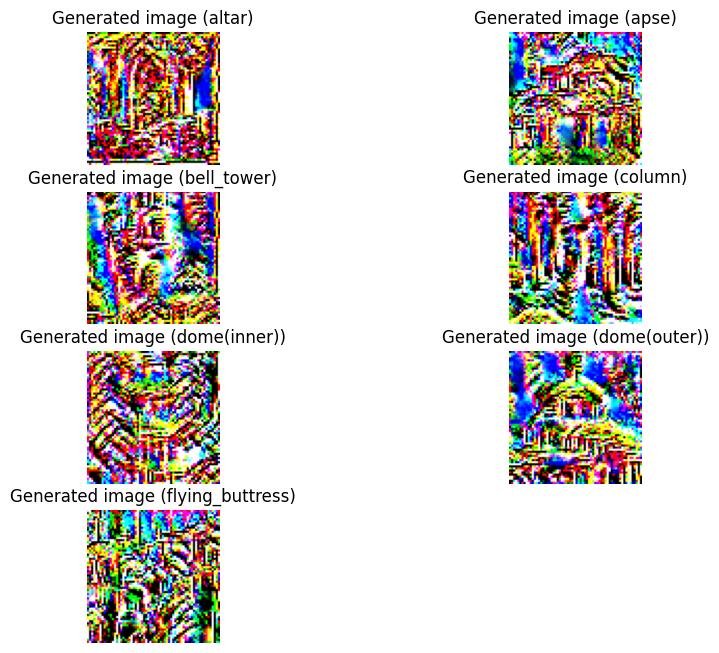

In [13]:
all_classes = test_dataset.classes
plt.figure(figsize=(10, 10))
for i, class_name in enumerate(all_classes):
    generated_image = generate_image_of_class(class_name, model, plot_initial=False)
    plt.subplot(5, 2, i+1)
    plt.imshow(generated_image)
    plt.title(f'Generated image ({class_name})')
    plt.axis('off')
plt.show()